In [115]:
# code aangepast van https://colab.research.google.com/github/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb#scrollTo=Dg82ndBA5xlN

In [116]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [117]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [118]:
# gebruik pretrained model (cased!): https://huggingface.co/GroNLP/bert-base-dutch-cased
from transformers import AutoTokenizer, AutoModel, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stre

In [119]:
# inladen data
dataset_path = "~/share/Milena/programma-discriminatie-en-racisme/datasets/"
dataset_zoek = pd.read_csv(dataset_path + 'dataset_milena_3.csv', sep = ';') # model is te groot om te trainen met volledige dataset zonder GPU

In [120]:
# hoe veel komt discriminatie voor in de dataset?
print(dataset_zoek.columns)

display(dataset_zoek)

Index(['Id', 'pagina', 'zin', 'Id_hoofddocument', 'Soort', 'DocumentNummer',
       'Titel', 'Onderwerp', 'Datum', 'Vergaderjaar', 'Kamer', 'Volgnummer',
       'Citeertitel', 'Alias', 'DatumRegistratie', 'DatumOntvangst',
       'Aanhangselnummer', 'KenmerkAfzender', 'Organisatie', 'ContentType',
       'ContentLength', 'GewijzigdOp', 'ApiGewijzigdOp', 'Verwijderd',
       'url_document', 'type_document', 'text', 'word', 'categorie', 'doel',
       'voorkeur', 'vermijden', 'toelichting'],
      dtype='object')


,Id,pagina,zin,Id_hoofddocument,Soort,DocumentNummer,Titel,Onderwerp,Datum,Vergaderjaar,...,Verwijderd,url_document,type_document,text,word,categorie,doel,voorkeur,vermijden,toelichting
0,d4cfb963-de8d-400e-bb87-5493b794a255,1,1,4adc7375-fb7e-41b3-bc0d-001be33502c8,Bijlage,2024D05829,NaN,Beslisnota bij Kamerbrief over Geografische Ba...,2024-02-15T00:00:00+01:00,2023-2024,...,False,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,ter besluitvorming nota actief openbaar ja onz...,slavernijverleden,kolonialisme,context,NaN,NaN,NaN
1,d4cfb963-de8d-400e-bb87-5493b794a255,1,2,4adc7375-fb7e-41b3-bc0d-001be33502c8,Bijlage,2024D05829,NaN,Beslisnota bij Kamerbrief over Geografische Ba...,2024-02-15T00:00:00+01:00,2023-2024,...,False,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,bij deze nota vindt u die brief aan de tweede ...,NaN,NaN,NaN,NaN,NaN,NaN
2,d4cfb963-de8d-400e-bb87-5493b794a255,1,3,4adc7375-fb7e-41b3-bc0d-001be33502c8,Bijlage,2024D05829,NaN,Beslisnota bij Kamerbrief over Geografische Ba...,2024-02-15T00:00:00+01:00,2023-2024,...,False,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,geadviseerd besluit  instemmen met verzenden ...,NaN,NaN,NaN,NaN,NaN,NaN
3,d4cfb963-de8d-400e-bb87-5493b794a255,1,4,4adc7375-fb7e-41b3-bc0d-001be33502c8,Bijlage,2024D05829,NaN,Beslisnota bij Kamerbrief over Geografische Ba...,2024-02-15T00:00:00+01:00,2023-2024,...,False,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,de brief is parallel voorgelegd aan mbz en doo...,NaN,NaN,NaN,NaN,NaN,NaN
4,d4cfb963-de8d-400e-bb87-5493b794a255,1,5,4adc7375-fb7e-41b3-bc0d-001be33502c8,Bijlage,2024D05829,NaN,Beslisnota bij Kamerbrief over Geografische Ba...,2024-02-15T00:00:00+01:00,2023-2024,...,False,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,kern  in deze brief wordt de kamer geïnformee...,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567229,490faff2-b50c-4a78-afdc-f36ed34ed3df,15,7,039b8016-60d5-4d37-a550-ff76e8e8053e,Bijlage,2024D07580,NaN,"Quick scan Financiële impact maatregelen ""Voor...",2024-03-01T00:00:00+01:00,2023-2024,...,False,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,15,NaN,NaN,NaN,NaN,NaN,NaN
567230,490faff2-b50c-4a78-afdc-f36ed34ed3df,16,1,039b8016-60d5-4d37-a550-ff76e8e8053e,Bijlage,2024D07580,NaN,"Quick scan Financiële impact maatregelen ""Voor...",2024-03-01T00:00:00+01:00,2023-2024,...,False,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,quick scan d.d.,NaN,NaN,NaN,NaN,NaN,NaN
567231,490faff2-b50c-4a78-afdc-f36ed34ed3df,16,2,039b8016-60d5-4d37-a550-ff76e8e8053e,Bijlage,2024D07580,NaN,"Quick scan Financiële impact maatregelen ""Voor...",2024-03-01T00:00:00+01:00,2023-2024,...,False,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,22-02-2024 kalveren: binnen bestaande stal inv...,blank,kolonialisme,context/vermijden,wit,blank,in context van mensen
567232,490faff2-b50c-4a78-afdc-f36ed34ed3df,17,1,039b8016-60d5-4d37-a550-ff76e8e8053e,Bijlage,2024D07580,NaN,"Quick scan Financiële impact maatregelen ""Voor...",2024-03-01T00:00:00+01:00,2023-2024,...,False,https://gegevensmagazijn.tweedekamer.nl/OData/...,Bijlage,quick scan d.d.,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
# tokenization, padding, masking
# LET OP: TRUNCATION = TRUE KORT DE ZINNEN IN TOT MAX. 512 TEKENS. NOG BESPREKEN
tokenized = dataset_zoek['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation = True)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

np.array(padded).shape

attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [20]:
# trainen
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
features = last_hidden_states[0][:,0,:].numpy()

labels = dataset_zoek['word']

In [21]:
# split dataset in train, test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [22]:
# trainen model (logistic regression)
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# testen (logistic model)
lr_clf.score(test_features, test_labels)

0.536

In [95]:
# sentiment analysis
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("wietsedv/bert-base-dutch-cased-finetuned-sentiment")
model = AutoModel.from_pretrained("wietsedv/bert-base-dutch-cased-finetuned-sentiment")  # PyTorch

Some weights of the model checkpoint at wietsedv/bert-base-dutch-cased-finetuned-sentiment were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [96]:
print(dataset_zoek['text'])

0                                                     ...
1                              Onze referentie\nVerdel...
2       groeifaciliteit voor de  23987, nr.   aanspraa...
3       hoofdstuk 01 | Inleiding                      ...
4       hoofdstuk 03 | Effectiviteit, resultaten, nade...
                              ...                        
6328                                     QUICK SCAN D....
6329                                        QUICK SCAN...
6330                                         QUICK SCA...
6331                                             QUICK...
6332                                           QUICK S...
Name: text, Length: 6333, dtype: object


In [99]:
pipe = pipeline("text-classification", model="wietsedv/bert-base-dutch-cased-finetuned-sentiment", return_all_scores=True)

for i in range(10, 30):
    print(pipe(dataset_zoek.loc[i, 'text']))
    print(dataset_zoek.loc[i, 'text'])

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [69]:
# inladen data
dataset_path = "~/share/Milena/programma-discriminatie-en-racisme/datasets/"
datasetDR = pd.read_csv(dataset_path + "documenten.csv")

# inladen lijst discriminerende termen
zoekwoorden = pd.read_excel(dataset_path + "Zoekwoorden15.03.24.xlsx", names = ['Categorie', 'Zoekwoord', 'Doel', 'Voorkeur', 'Vermijden', 'Toelichting'])

zoekwoorden = zoekwoorden.drop([0, 1, 2])

In [122]:
aanwezig = []
niet_aanwezig = []

for woord in dataset_zoek['word']:
    if woord in aanwezig:
        pass
    else:
        aanwezig.append(woord)
        
for woord in zoekwoorden['Zoekwoord']:
    if woord in aanwezig:
        pass
    else:
        niet_aanwezig.append(woord)

print(aanwezig, len(aanwezig))
print(niet_aanwezig, len(niet_aanwezig))
print(zoekwoorden['Zoekwoord'], len(zoekwoorden['Zoekwoord']))

['slavernijverleden', nan, 'ontwikkelingslanden', 'vrouw', 'geslacht', 'west', 'ras', 'handicap', 'zwart', 'jongen', 'meisje', 'ouders', 'begeleider', 'stroom', 'blank', 'stromen', 'ontdekking', 'ontdekken', 'page', 'privilege', 'man', 'islam', 'gekleurd', 'racisme', 'hetero', 'traditie', 'macht', 'homo', 'hoofddoek', 'kloof', 'juf', 'donker', 'seksueel', 'armoede', 'migranten', 'turk', 'minderheden', 'zittenblijven', 'achterstandsscore', 'mavo', 'christen', 'nieuwkomer', 'verliefd', 'laagopgeleid', 'hoogopgeleid', 'joods', 'transgender', 'westers', 'allochtoon', 'etnisch', 'gehandicapt', 'zigeuner', 'gebarentolk', 'rolstoelgebonden', 'arabisch', 'bediende', 'bruin', 'vluchtelingencrisis', 'achterstandsscholen', 'tussenpositie', 'queer', 'doventolk', 'berber', 'lagelonenlanden'] 64
['Andere achtergrond', 'fobie', 'dwerg', 'rolstoeler', 'rolstoelrijder', 'grensoverschrijdend gedrag', 'bi-cultureel', 'Islamiet', 'Mohammedaan', 'islam ', 'hermafrodiet', 'dames en heren', 'hij of zij', 'hi

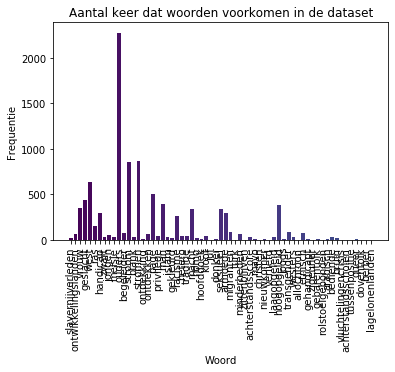

In [124]:
# leuk grafiekje van hoe vaak woorden voorkomen
word_freq = {}

for woord in dataset_zoek['word']:
    if woord in word_freq:
        word_freq[woord] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[woord] = 1
        
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de dataset')
plt.show()

In [137]:
# laten we kijken naar specifieke zinnen
def vind_zinnen(woord):
    for i in range(len(dataset_zoek)):
        if dataset_zoek['word'].iloc[i] == woord:
            print(dataset_zoek['text'].iloc[i])
            print("DOCUMENT:")
            print(dataset_zoek['Onderwerp'].iloc[i])
            
vind_zinnen('homo')

ze zeiden letterlijk eerste instantie. bij mijn sollicitatie ‘we zijn blij dat je homo bent, dan krijg je geen deelnemers die op meerdere vlakken te maken hebben met kinderen en hoef je geen verlof’.’ ongelijke behandeling, ervaren dat dit hen verder op achterstand zet: ‘als vrouw sta je intersectionaliteit gedurende de dialogen over gelijkwaardige ‘als vrouw sta 1-0 achter, maar als vrouw met hoofddoek sta kansen op de arbeidsmarkt vertellen veel deel- je 1-0 achter, je 2-0 achter.’
DOCUMENT:
Rapportage fase 1 dialoog SamenSpraak
dat betekent dat google gebruikmaakt van algoritmen die woorden als homo, lesbisch en 11
DOCUMENT:
Rapport Kunstmatige intelligentie en lhbti+ emancipatie
mainstream datingapps zoals tinder maken het steeds meer mogelijk iemands seksuele oriëntatie te selecteren of bouwen een veiligheidsfunctie in voor lhbti+ gebruikers wanneer ze naar landen reizen waar homo zijn nog steeds illegaal is).
DOCUMENT:
Rapport Kunstmatige intelligentie en lhbti+ emancipatie
uit o

In [141]:
# Rapportage fase 1 dialoog SamenSpraak
# dit document splitsen in zinnen en beschikbaar maken voor labelling

# als de data wordt aangeleverd in paragraafformat
def generate_to_label_paragrafen(document):
    kolommen = ['document', 'text', 'zin']
    data = []
    paragrafen = []
    woorden = []
    
    # isolate sentences based on '.' or '!' or '?'
    for i in range(len(dataset_zoek)):
        if dataset_zoek['Onderwerp'].iloc[i] == document:
            # voorkomen dat paragrafen dubbel worden opgenomen
            paragraaf = dataset_zoek['text'].iloc[i]
            document = dataset_zoek['Onderwerp'].iloc[i]
            if paragraaf not in paragrafen:
                paragrafen.append(paragraaf)
                zinnen = paragraaf.split(sep = '.')
                
                for zin in zinnen:
                    data.append([document, paragraaf, zin])
    to_label = pd.DataFrame(data, columns = kolommen)
    return(to_label)

# als de data al is gesplitst in zinnen
def generate_to_label_zinnen(document):
    kolommen = ['document', 'text', 'zin']
    data = []
    paragrafen = []
    woorden = []
    
    # isolate sentences based on '.' or '!' or '?'
    for i in range(len(dataset_zoek)):
        if dataset_zoek['Onderwerp'].iloc[i] == document:
            # voorkomen dat paragrafen dubbel worden opgenomen
            zin = dataset_zoek['text'].iloc[i]
            document = dataset_zoek['Onderwerp'].iloc[i]
            
            # voeg voorgaande en opvolgende zin toe om context mee te geven
            if i == 0:
                paragraaf = dataset_zoek['text'].iloc[i] + dataset_zoek['text'].iloc[i+1]
            elif i == len(dataset_zoek):
                paragraaf = dataset_zoek['text'].iloc[i-1] + dataset_zoek['text'].iloc[i]
            else:
                paragraaf = dataset_zoek['text'].iloc[i-1] + dataset_zoek['text'].iloc[i] + dataset_zoek['text'].iloc[i+1]
            data.append([document, paragraaf, zin])
    to_label = pd.DataFrame(data, columns = kolommen)
    return(to_label)
                    
data_for_labelling = generate_to_label_zinnen('Rapportage fase 1 dialoog SamenSpraak')
data_for_labelling['label'] = ''
data_for_labelling['score_1'] = ''
data_for_labelling['score_2'] = ''
data_for_labelling['score_3'] = ''
data_for_labelling['totaalscore'] = ''

display(data_for_labelling)

,document,text,zin,label,score_1,score_2,score_3,totaalscore
0,Rapportage fase 1 dialoog SamenSpraak,ons hoofkantoor is gevestigd in nederland en w...,"“ik vind het wel belangrijk, maar...”",,,,,
1,Rapportage fase 1 dialoog SamenSpraak,"“ik vind het wel belangrijk, maar...”onderzo...",onderzoek onder de beroepsbevolking naar keuze...,,,,,
2,Rapportage fase 1 dialoog SamenSpraak,onderzoek onder de beroepsbevolking naar keuze...,onderzoeksrapportage fase 1 in opdracht van mi...,,,,,
3,Rapportage fase 1 dialoog SamenSpraak,onderzoeksrapportage fase 1 in opdracht van mi...,inhoud 1.,,,,,
4,Rapportage fase 1 dialoog SamenSpraak,inhoud 1.samenvatting 3 2.inleiding 6 3.,samenvatting 3 2.,,,,,
...,...,...,...,...,...,...,...,...
932,Rapportage fase 1 dialoog SamenSpraak,"dat zijn in ieder geval burgers, werk- gevers ...",‘ik vind het wel belangrijk maar…’ p. 43 van 45,,,,,
933,Rapportage fase 1 dialoog SamenSpraak,‘ik vind het wel belangrijk maar…’ p. 43 van 4...,factsheet leeftijd 70 - 80 onbekend 10 - 20 60...,,,,,
934,Rapportage fase 1 dialoog SamenSpraak,factsheet leeftijd 70 - 80 onbekend 10 - 20 60...,factsheet leeftijd 70 - 80 onbekend 10 - 20 60...,,,,,
935,Rapportage fase 1 dialoog SamenSpraak,factsheet leeftijd 70 - 80 onbekend 10 - 20 60...,colofon samenspraak is een project dat in opdr...,,,,,


In [131]:
# voeg een sentiment analysis feature toe
pipe = pipeline("text-classification", model="wietsedv/bert-base-dutch-cased-finetuned-sentiment", return_all_scores=True)

negatives = 0
positives = 0
neutrals = 0

for i in range(len(data_for_labelling)):
    label = pipe(data_for_labelling.loc[i, 'text'])
    neg_label = label[0][0]['score']
    pos_label = label[0][1]['score']
    if neg_label > pos_label:
        data_for_labelling['label'] = 'negatief'
        negatives += 1
    elif neg_label < pos_label:
        data_for_labelling['label'] = 'positief'
        positives +=1
    else:
        data_for_labelling['label'] = 'neutraal'
        neutrals += 1
        
print(positives, negatives, neutrals)

955 1151 0


In [ ]:
# optioneel: exporteer naar .csv
#export_path = 'milenadeswart/share/Milena/programma-discriminatie-en-racisme/datasets/'
#datasetDR.to_csv('dataset_te_labellen.csv')